In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import io
import imageio
import cv2
import sys
#from pytorch_msssim import ssim
from skimage.metrics import structural_similarity as ssim
import pickle 
import torchvision
from ipywidgets import widgets, HBox

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# import os, os.path, glob

# #Radar = np.zeros((458, 250, 501, 501))
# file_counter = 0
# global_ans = []
# gc=0
# for foldername in os.listdir("nh_radar_comp_echo/"):
#     if foldername=='.DS_Store':
#         continue
# #     if gc>=5:
# #         break
#     gc+=1
#     list = os.listdir("nh_radar_comp_echo/"+foldername) # dir is your directory path
#     number_files = len(list)
#     print(gc, ": ", number_files)
#     if number_files<240:
#         continue
#     file_counter+=1
#     ls = []
#     counter = 0 
#     for filename in sorted(os.listdir("nh_radar_comp_echo/"+foldername)):
#         if counter>=240:
#             break
#         counter+=1
#         #print(foldername+"/"+filename)
#         #img = Image.open("nh_radar_comp_echo/"+foldername+"/"+filename)
#         img = cv2.imread("nh_radar_comp_echo/"+foldername+"/"+filename) 
#         img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
#         #print('shape of img:', img.shape)
#         np_img = np.array(img)
#         #Radar[file_counter-1][counter-1] = np_img
#         #print(np_img.shape)
#         ls.append(np_img)
#     f = np.asarray(ls)
#     #print(type(f))
#     global_ans.append(f)
# Radar3 = np.asarray(global_ans)
# np.save('unet_radar_128_3', Radar3)


In [2]:
Radar = np.load('new_radar_20_128fr_cleaned.npy')

In [3]:
print(type(Radar))
print(Radar.shape)
print(Radar.itemsize)

<class 'numpy.ndarray'>
(2901, 20, 128, 128)
1


In [5]:
#Radar2.resize((5784, 20, 128, 128))

In [6]:
# print(np.max(Radar2))
# print(np.min(Radar2))

In [7]:
# from scipy.stats import iqr

# op = []
# for i in range(0, 5725):
#     for j in range(0, 20):
#         op.append(np.sum(Radar2[i][j]))
        
# st = np.asarray(op)
# print(st.shape)

In [8]:
# n25 = np.percentile(st, 25)
# n75 = np.percentile(st, 75)

# print(n25, n75)

In [9]:
# gl = []
# maxp = -1
# minp = sys.maxsize
# for i in range(0, 5725):
#     no_bad = 0;
#     for j in range(0, 20):
#         sum_fr = np.sum(Radar2[i][j])
#         if sum_fr<n25 or sum_fr>n75:
#             no_bad+=1
#     if no_bad<=10:
#         gl.append(Radar2[i])
# Radar = np.asarray(gl)

In [4]:
np.random.shuffle(Radar)
print(Radar.shape)

(2901, 20, 128, 128)


In [5]:
# Train, Test, Validation splits
train_data = Radar[:2000]         
val_data = Radar[2000:2500]       
test_data = Radar[2500:2900]     

def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(16,20)                     
    return batch[:,:,rand-16:rand], batch[:,:,rand]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=2, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=2, collate_fn=collate)

In [6]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        #print(x.shape)
        y = self.conv1(x)
        #print('surpassed this')
        return self.conv2(self.relu(y))


class Encoder(nn.Module):
    #def __init__(self, chs=(3,64,128,256,512,1024)):
    def __init__(self, chs=(16,64,128,256)):
        super().__init__()
        l = [Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]
        #print(l)
        self.enc_blocks = nn.ModuleList(l)
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            #print('enc block output:', x.shape)
            ftrs.append(x)
            #print('ftrs shape:', x.shape)
            x = self.pool(x)
            #print('after pool:', x.shape)
        return ftrs


class Decoder(nn.Module):
    #def __init__(self, chs=(1024, 512, 256, 128, 64)):
    def __init__(self, chs=(256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        #print(len(x), len(encoder_features))
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            #print('forward to crop x and enc:', x.shape, encoder_features[i].shape)
            enc_ftrs = self.crop(encoder_features[i], x)
            #print('forward shapes of x and enc_fts:', x.shape, enc_ftrs.shape)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        #print('crop output shape', enc_ftrs.shape)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(16,64,128,256), dec_chs=(256, 128, 64), num_class=1, retain_dim=False, out_sz=(128,128)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        #for ftr in enc_ftrs: print(ftr.shape)
        #print('decoder input:', enc_ftrs[::-1][0].shape, enc_ftrs[::-1][1:].shape)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        #print('decoder output:', out.shape)
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [7]:
model = UNet().to(device)
optim = Adam(model.parameters(), lr=1e-3)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.MSELoss(reduction='sum')

num_epochs = 5

In [8]:
def calculate_psnr(target, output):
    """
    Calculate Peak Signal To Noise Ratio
    Input: torch tensor of shape (m, C, H, W)
    Output: average of PSTR for that batch
    """
    
    m, C, H, W = target.shape
    sum_psnr = 0 
    
    for i in range(m):
        output[i] = torch.clamp(output[i], min=0.0, max=1.0)
        mse = torch.sum((target[i] - output[i])**2)/(C*H*W)
        psnr =  -10*torch.log10(mse)
        sum_psnr += psnr
        
    return sum_psnr

In [9]:


epi=0
ep = []
tr_loss = []
va_loss = []
for epoch in range(1, num_epochs+1):
    epi+=1
    train_loss = 0 
    psnr_train = 0
    psnr_val =0
    ssim_train = 0
    ssim_val = 0
    model.train()                                                  
    for batch_num, (input, target) in enumerate(train_loader, 1):  
        input = torch.squeeze(input, axis=1)
        #print(type(input), input.shape)
        #input = input.permute(0, 4, 1, 2, 3)
        #print('input shape:', input.shape)
        output = model(input) 
        #print(output)
        #print('output shape:', output.shape, 'target shape:', target.shape)
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()
        psnr_train+=calculate_psnr(target, output)
        ot = output.flatten().cpu()
        tt = target.flatten().cpu()
        ssim_train+=ssim(ot.detach().numpy(), tt.detach().numpy())
        #ssim_train+=ssim(output, target)
    train_loss /= len(train_loader.dataset)  
    psnr_train/= len(train_loader.dataset) 
    ssim_train/=len(train_loader.dataset)
    tr_loss.append(train_loss)
    
    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:  
            input = np.squeeze(input, axis=1)
            output = model(input)   
            #output = output.permute(0, 2, 3, 4, 1)
            #output = torch.unsqueeze(output, axis = 1)
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()
            psnr_val+=calculate_psnr(target, output)
            ot = output.flatten().cpu()
            tt = target.flatten().cpu()
            ssim_val+=ssim(ot.detach().numpy(), tt.detach().numpy())
            #ssim_val+=ssim(output, target)
    val_loss /= len(val_loader.dataset) 
    psnr_val/= len(val_loader.dataset)
    ssim_val/=len(val_loader.dataset)
    va_loss.append(val_loss)
    #print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        #epoch, train_loss, val_loss))
    print("Epoch:{} Training Loss:{:.2f} psnr_train:{:.2f} ssim_train:{:.2f} Validation Loss:{:.2f} psnr_val:{:.2f} ssim_val:{:.2f}\n".format(
        epoch, train_loss, psnr_train, ssim_train, val_loss, psnr_val, ssim_val))

Epoch:1 Training Loss:2.30 psnr_train:44.16 ssim_train:0.49 Validation Loss:1.23 psnr_val:45.12 ssim_val:0.49

Epoch:2 Training Loss:1.60 psnr_train:45.48 ssim_train:0.49 Validation Loss:1.25 psnr_val:45.03 ssim_val:0.49

Epoch:3 Training Loss:1.17 psnr_train:46.37 ssim_train:0.50 Validation Loss:1.03 psnr_val:46.28 ssim_val:0.50

Epoch:4 Training Loss:1.10 psnr_train:46.64 ssim_train:0.50 Validation Loss:1.05 psnr_val:44.13 ssim_val:0.49

Epoch:5 Training Loss:0.96 psnr_train:47.01 ssim_train:0.50 Validation Loss:0.90 psnr_val:46.76 ssim_val:0.50



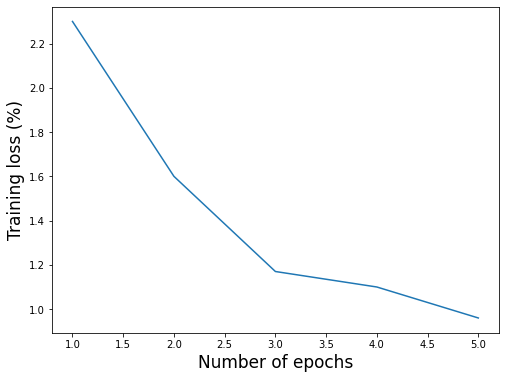

In [101]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.xlabel("Number of epochs", fontsize = 17)
plt.ylabel("Training loss (%)", fontsize = 17)


plt.plot(ep, tr_loss)
plt.show()

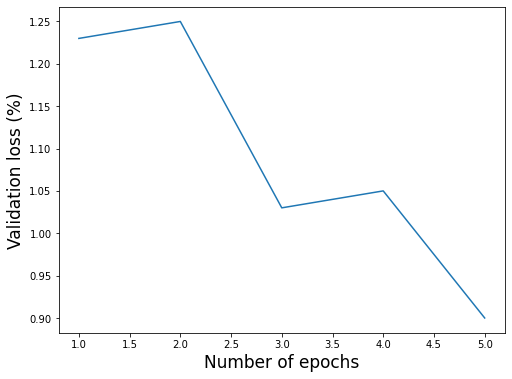

In [102]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.xlabel("Number of epochs", fontsize = 17)
plt.ylabel("Validation loss (%)", fontsize = 17)


plt.plot(ep, va_loss)
plt.show()

In [33]:
Pkl_Filename = "psnr_ssim_modelUNet_5ep_2bs_3ks.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [9]:
with open('psnr_ssim_modelUNet_5ep_2bs_3ks.pkl', 'rb') as file:  
    model = pickle.load(file)

In [10]:
def collate_test(batch):

    # Last 10 frames are target
    target = np.array(batch)[:,16:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=3, collate_fn=collate_test)


# Get a batch
batch, target = next(iter(test_loader))

In [11]:
# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
for timestep in range(target.shape[1]):
    input = batch[:,:,timestep:timestep+16] 
    input = torch.squeeze(input, axis=1)
    last_out = model(input).squeeze(1).cpu()
    #output image copied in the batch from which we are taking the 
    #next input, hence using the current output image as input 
    #for next frame prediction. By doing so, we predict 4 frames in
    #future by using current 16 frames
    batch[:,:,16+timestep] = torch.unsqueeze(last_out, dim=1) 
    output[:,timestep]=(last_out>0.07)*255.0

In [12]:
for tgt, out in zip(target, output):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 2)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 2)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif, height=400, width=400), 
                  widgets.Image(value=output_gif, height=400, width=400)]))

In [13]:
test_loader_nu = DataLoader(test_data, shuffle=True, 
                        batch_size=1, collate_fn=collate)

ssim_test = 0
psnr_test = 0

model.eval()                                                   
with torch.no_grad():                                          
    for input, target in test_loader_nu:  
        input = np.squeeze(input, axis=1)
        output = model(input)   
        output = torch.mean(output, 1)
        output = torch.unsqueeze(output, dim=1) 
        psnr_test+=calculate_psnr(target, output)
        ot = output.flatten().cpu()
        tt = target.flatten().cpu()
        ssim_test+=ssim(ot.detach().numpy(), tt.detach().numpy())
psnr_test/= len(test_loader_nu.dataset)
ssim_test/=len(test_loader_nu.dataset)
print("PSNR for test dataset: {:.2f}", psnr_test)
print("SSIM for test dataset: {:.2f}", ssim_test)

PSNR for test dataset: {:.2f} tensor(47.2862, device='cuda:0')
SSIM for test dataset: {:.2f} 0.9929335054807256


In [15]:
print("PSNR for test dataset: {:.8f}".format(psnr_test.item()))
print("SSIM for test dataset: {:.8f}".format(ssim_test))

PSNR for test dataset: 47.28620148
SSIM for test dataset: 0.99293351
